In [1]:
import pandas as pd
import numpy as np
from   category_encoders       import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from   sklearn.compose         import *
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from   sklearn.metrics         import * 
from   sklearn.preprocessing   import *
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.linear_model  import Lasso, Ridge, ElasticNet, HuberRegressor, BayesianRidge


import warnings
warnings.filterwarnings('ignore')
import joblib

## Initial EDA

In [2]:
df = pd.read_csv('train.csv')

From the Kaggle competiton page, we are given the following data dictionary:


| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

In [3]:
df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age is missing quite a few values, we will deal with that in our preprocessing pipeline.

Let's look at the distribution of values in some of our features.

In [5]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [6]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
df["Cabin"].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
F2             3
D              3
              ..
C30            1
B101           1
E50            1
C101           1
C54            1
Name: Cabin, Length: 147, dtype: int64

In [8]:
df["Cabin"].isna().sum() / len(df["Cabin"]) # 77% of the feature is missing, I doubt this will be very helpful

0.7710437710437711

I always like to do a quick look at correlations in my data set to see if anything interesting pops up.

In [9]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Seems that there is a high postive correlation between fare and the survival columns. Additionally, we se a strong negative correlation between Pclass and sruvived columns.

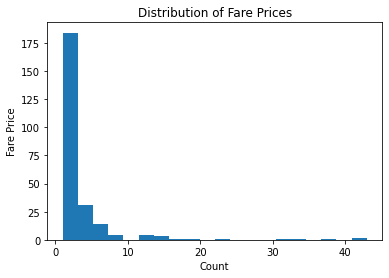

In [10]:
fig, ax = plt.subplots()
ax.hist(df['Fare'].value_counts(), bins=20)
ax.set_title('Distribution of Fare Prices')
ax.set_xlabel('Count')
ax.set_ylabel('Fare Price')
plt.show()

Let's get the data ready to model.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We will handle categorical variables in our preprocessing 

Here we remove ticket, cabin, passengerid, and name as we do not want to include features that are simply going to be unique identifiers for each person. This could lead to the model overfitting to these features and then not being able to generalize well. We remove cabin however, as we saw in our EDA that 77% of observations were missing a cabin 

In [12]:
categorical_columns = ['Embarked','Sex']
numerical_columns = ['Pclass','Age','SibSp','Parch','Fare']


con_pipe = Pipeline([('scaler', MinMaxScaler()),
                      ('imputer', SimpleImputer(strategy='median', add_indicator=True))])

cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                     ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))])

preprocessing = ColumnTransformer([('categorical', cat_pipe,  categorical_columns),
                                   ('continuous',  con_pipe, numerical_columns),
                                   ])

Now the data is ready to be modeled.

In [13]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [15]:
pipe_rf= Pipeline([('preprocessing', preprocessing), 
                 ('clf', RandomForestClassifier())])


pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))]),
                                                  ['Embarked', 'Sex']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                      

In [16]:
preds = pipe_rf.predict(X_val)

In [17]:
print(classification_report(preds, y_val))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       140
           1       0.71      0.78      0.75        83

    accuracy                           0.80       223
   macro avg       0.79      0.80      0.79       223
weighted avg       0.81      0.80      0.80       223



With no hyperparameter tuning we see ~80% accuracy, this is pretty good!

Let's also try logisitc regression!

In [18]:
pipe_lr= Pipeline([('preprocessing', preprocessing), 
                 ('lr', LogisticRegression())])


pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))]),
                                                  ['Embarked', 'Sex']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                      

In [19]:
preds = pipe_lr.predict(X_val)

In [20]:
print(classification_report(preds, y_val))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       151
           1       0.67      0.85      0.75        72

    accuracy                           0.82       223
   macro avg       0.79      0.82      0.80       223
weighted avg       0.84      0.82      0.82       223



Here we get basically the same result as the random forest, a great reminder of the no free lunch idea!

Let's see what happens when we introduce some regularization

In [21]:
pipe_lr_reg= Pipeline([('preprocessing', preprocessing), 
                 ('lr', LogisticRegression(penalty='l1', solver='liblinear', max_iter=500))])


pipe_lr_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))]),
                                                  ['Embarked', 'Sex']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('imputer',
                                                      

In [22]:
preds = pipe_lr_reg.predict(X_val)

In [23]:
print(classification_report(preds, y_val))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       151
           1       0.66      0.83      0.74        72

    accuracy                           0.81       223
   macro avg       0.78      0.81      0.79       223
weighted avg       0.83      0.81      0.81       223



Let's put our models to the test. First, we have to take care of a couple of transformations so we do not run into issues!

In [24]:
test = pd.read_csv('test.csv')

In [27]:
res = pd.DataFrame(pipe_lr.predict(test), columns = ['Survived'])

res['PassengerId'] = test['PassengerId']

res.to_csv('sub.csv',index=None)

In [29]:
res2 = pd.DataFrame(pipe_rf.predict(test), columns = ['Survived'])

res2['PassengerId'] = test['PassengerId']

In [30]:
res2.to_csv('sub2.csv',index=None)

My first "real" kaggle competition!